In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import date, datetime, timedelta
from sklearn.metrics import accuracy_score

In [4]:
market_train_df = pd.read_csv("dataset/market_train_df.csv")
news_train_df = pd.read_csv("dataset/news_train_df.csv")

In [5]:
market_train_df = market_train_df.astype({
    'time': 'datetime64',
    'assetCode': 'object',
    'assetName': 'category',
    'universe': 'float64',
    'volume': 'float64',
    'close': 'float64',
    'open': 'float64',
    'returnsClosePrevRaw1': 'float64',
    'returnsOpenPrevRaw1': 'float64',
    'returnsClosePrevMktres1': 'float64',
    'returnsOpenPrevMktres1': 'float64',
    'returnsClosePrevRaw10': 'float64',
    'returnsOpenPrevRaw10': 'float64',
    'returnsClosePrevMktres10': 'float64',
    'returnsOpenPrevMktres10': 'float64',
    'returnsOpenNextMktres10': 'float64'
})

In [6]:
news_train_df = news_train_df.astype({
    'time': 'datetime64',
    'sourceTimestamp': 'datetime64',
    'firstCreated': 'datetime64',
    'sourceId': 'object',
    'headline': 'object',
    'urgency': 'int8',
    'takeSequence': 'int16',
    'provider': 'category',
    'subjects': 'category',
    'audiences': 'category',
    'bodySize': 'int32',
    'companyCount': 'int8',
    'headlineTag': 'object',
    'marketCommentary': 'bool',
    'sentenceCount': 'int16',
    'wordCount': 'int32',
    'assetCodes': 'category',
    'assetName': 'category',
    'firstMentionSentence': 'int16',
    'relevance': 'float32',
    'sentimentClass': 'int8',
    'sentimentNegative': 'float32',
    'sentimentNeutral': 'float32',
    'sentimentPositive': 'float32',
    'sentimentWordCount': 'int32',
    'noveltyCount12H': 'int16',
    'noveltyCount24H': 'int16',
    'noveltyCount3D': 'int16',
    'noveltyCount5D': 'int16',
    'noveltyCount7D': 'int16',
    'volumeCounts12H': 'int16',
    'volumeCounts24H': 'int16',
    'volumeCounts3D': 'int16',
    'volumeCounts5D': 'int16',
    'volumeCounts7D': 'int16'
})

In [7]:
print(market_train_df.dtypes)
print(news_train_df.dtypes)

Unnamed: 0                           int64
time                        datetime64[ns]
assetCode                           object
assetName                         category
volume                             float64
close                              float64
open                               float64
returnsClosePrevRaw1               float64
returnsOpenPrevRaw1                float64
returnsClosePrevMktres1            float64
returnsOpenPrevMktres1             float64
returnsClosePrevRaw10              float64
returnsOpenPrevRaw10               float64
returnsClosePrevMktres10           float64
returnsOpenPrevMktres10            float64
returnsOpenNextMktres10            float64
universe                           float64
dtype: object
Unnamed: 0                       int64
time                    datetime64[ns]
sourceTimestamp         datetime64[ns]
firstCreated            datetime64[ns]
sourceId                        object
headline                        object
urgency              

In [8]:
market_train_orig = market_train_df
news_train_orig = news_train_df

# Merge & clean data

In [9]:
start_date = date(2015,1,1)

# (market_train, _) = env.get_training_data()
market_train_df = market_train_orig.copy()
news_train_df = news_train_orig.copy()
print('Market train shape: ',market_train_df.shape)
print('News train shape: ', news_train_df.shape)

# Sort data
market_train_df = market_train_df.sort_values('time')
market_train_df['date'] = market_train_df['time'].dt.date

# Fill nan
market_train_fill = market_train_df
column_market = ['returnsClosePrevMktres1','returnsOpenPrevMktres1','returnsClosePrevMktres10', 'returnsOpenPrevMktres10']
column_raw = ['returnsClosePrevRaw1', 'returnsOpenPrevRaw1','returnsClosePrevRaw10', 'returnsOpenPrevRaw10']
for i in range(len(column_raw)):
    market_train_fill[column_market[i]] = market_train_fill[column_market[i]].fillna(market_train_fill[column_raw[i]])
market_train_orig = market_train_orig.sort_values('time')
news_train_orig = news_train_orig.sort_values('time')
market_train_df = market_train_orig.copy()
news_train_df = news_train_orig.copy()
del market_train_orig
del news_train_orig
market_train_df = market_train_df.loc[market_train_df['time'].dt.date>=start_date]
news_train_df = news_train_df.loc[news_train_df['time'].dt.date>=start_date]
market_train_df['close_open_ratio'] = np.abs(market_train_df['close']/market_train_df['open'])
threshold = 0.5
print('In %i lines price increases by 50%% or more in a day' %(market_train_df['close_open_ratio']>=1.5).sum())
print('In %i lines price decreases by 50%% or more in a day' %(market_train_df['close_open_ratio']<=0.5).sum())
market_train_df = market_train_df.loc[market_train_df['close_open_ratio'] < 1.5]
market_train_df = market_train_df.loc[market_train_df['close_open_ratio'] > 0.5]
market_train_df = market_train_df.drop(columns=['close_open_ratio'])

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
column_market = ['returnsClosePrevMktres1','returnsOpenPrevMktres1','returnsClosePrevMktres10', 'returnsOpenPrevMktres10']
column_raw = ['returnsClosePrevRaw1', 'returnsOpenPrevRaw1','returnsClosePrevRaw10', 'returnsOpenPrevRaw10']
#the top hundred words.
vectorizer = CountVectorizer(max_features=1000, stop_words={"english"})
#we do this with TF-IDF.
X = vectorizer.fit_transform(news_train_df['headline'].values)
tf_transformer = TfidfTransformer(use_idf=False).fit(X)
X_train_tf = tf_transformer.transform(X)
X_train_vals = X_train_tf.mean(axis=1)


del vectorizer
del X
del X_train_tf

#mean tf-idf score for news article.
d = pd.DataFrame(data=X_train_vals)
news_train_df['tf_score'] = d

market_train_df = market_train_df.loc[market_train_df['time'].dt.date>=start_date]
news_train_df = news_train_df.loc[news_train_df['time'].dt.date>=start_date]

#add indicator features
market_train_df['rolling_average_close_mean'] = market_train_df.groupby('assetCode')['close'].transform('mean')
market_train_df['rolling_average_vol_mean'] = market_train_df.groupby('assetCode')['volume'].transform('mean')
market_train_df['rolling_average_close_std'] = market_train_df.groupby('assetCode')['close'].transform('std')
market_train_df['rolling_average_vol_std'] = market_train_df.groupby('assetCode')['volume'].transform('std')
#some more refined instruments
market_train_df['moving_average_7_day'] = market_train_df.groupby('assetCode')['close'].transform(lambda x: x.rolling(window=7).mean())
ewma = pd.Series.ewm
market_train_df['ewma'] =  market_train_df.groupby('assetCode')['close'].transform(lambda x : ewma(x, span=30).mean())
market_train_df['moving_average_7_day'] = market_train_df['moving_average_7_day'].fillna(0)
market_train_df['ewma'] = market_train_df['ewma'].fillna(0)
for i in range(len(column_raw)):
    market_train_df[column_market[i]] = market_train_df[column_market[i]].fillna(market_train_df[column_raw[i]])
    print('Removing outliers ...')
column_return = column_market + column_raw + ['returnsOpenNextMktres10']
orig_len = market_train_df.shape[0]
for column in column_return:
    market_train_df = market_train_df.loc[market_train_df[column]>=-2]
    market_train_df = market_train_df.loc[market_train_df[column]<=2]
new_len = market_train_df.shape[0]
rmv_len = np.abs(orig_len-new_len)
print('There were %i lines removed' %rmv_len)
print('Removing strange data ...')
orig_len = market_train_df.shape[0]
market_train_df = market_train_df[~market_train_df['assetCode'].isin(['PGN.N','EBRYY.OB'])]
#market_train_df = market_train_df[~market_train_df['assetName'].isin(['Unknown'])]
new_len = market_train_df.shape[0]
rmv_len = np.abs(orig_len-new_len)
print('There were %i lines removed' %rmv_len)
# Function to remove outliers
def remove_outliers(data_frame, column_list, low=0.02, high=0.98):
    for column in column_list:
        this_column = data_frame[column]
        quant_df = this_column.quantile([low,high])
        low_limit = quant_df[low]
        high_limit = quant_df[high]
        data_frame[column] = data_frame[column].clip(lower=low_limit, upper=high_limit)
    return data_frame
columns_outlier = ['takeSequence', 'bodySize', 'sentenceCount', 'wordCount', 'sentimentWordCount', 'firstMentionSentence','noveltyCount12H',\
                  'noveltyCount24H', 'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H', 'volumeCounts24H',\
                  'volumeCounts3D','volumeCounts5D','volumeCounts7D']
print('Clipping news outliers ...')
news_train_df = remove_outliers(news_train_df, columns_outlier)
asset_code_dict = {k: v for v, k in enumerate(market_train_df['assetCode'].unique())}
drop_columns = [col for col in news_train_df.columns if col not in ['sourceTimestamp', 'urgency', 'takeSequence', 'bodySize', 'companyCount', 
               'sentenceCount', 'firstMentionSentence', 'relevance','firstCreated', 'assetCodes']]
columns_news = ['firstCreated','relevance','sentimentClass','sentimentNegative','sentimentNeutral',
               'sentimentPositive','noveltyCount24H','noveltyCount7D','volumeCounts24H','volumeCounts7D','assetCodes','sourceTimestamp',
               'assetName','audiences', 'urgency', 'takeSequence', 'bodySize', 'companyCount', 
               'sentenceCount', 'firstMentionSentence','time', 'tf_score']
def data_prep(market_df,news_df):
    market_df['date'] = market_df.time.dt.date
    market_df['close_to_open'] = market_df['close'] / market_df['open']
    market_df.drop(['time'], axis=1, inplace=True)
    
    news_df = news_df[columns_news]
    news_df['sourceTimestamp']= news_df.sourceTimestamp.dt.hour
    news_df['firstCreated'] = news_df.firstCreated.dt.date
    news_df['assetCodesLen'] = news_df['assetCodes'].map(lambda x: len(eval(x)))
    news_df['assetCodes'] = news_df['assetCodes'].map(lambda x: list(eval(x))[0])
    news_df['asset_sentiment_count'] = news_df.groupby(['assetName', 'sentimentClass'])['time'].transform('count')
    news_df['len_audiences'] = news_train_df['audiences'].map(lambda x: len(eval(x)))
    kcol = ['firstCreated', 'assetCodes']
    news_df = news_df.groupby(kcol, as_index=False).mean()
    market_df = pd.merge(market_df, news_df, how='left', left_on=['date', 'assetCode'], 
                            right_on=['firstCreated', 'assetCodes'])
    del news_df
#     market_df['assetCodeT'] = market_df['assetCode'].map(asset_code_dict)
    market_df = market_df.drop(columns = ['firstCreated','assetCodes','assetName']).fillna(0) 
#     print(market_df.count)
    return market_df
print('Merging data ...')
market_train_df = data_prep(market_train_df, news_train_df)
market_train_df = market_train_df.loc[market_train_df['date']>=start_date]
market_train = market_train_df

del market_train_df

Market train shape:  (4072956, 17)
News train shape:  (9328750, 36)
In 13 lines price increases by 50% or more in a day
In 1 lines price decreases by 50% or more in a day
Removing outliers ...
Removing outliers ...
Removing outliers ...
Removing outliers ...
There were 74 lines removed
Removing strange data ...
There were 94 lines removed
Clipping news outliers ...
Merging data ...


/home/lab/isabella/.pyenv/versions/anaconda3-2019.03/envs/ubuntu-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lab/isabella/.pyenv/versions/anaconda3-2019.03/envs/ubuntu-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lab/isabella/.pyenv/versions/anaconda3-2019.03/envs/ubuntu-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set o

In [10]:
market_train.describe().round(3)

,Unnamed: 0,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,...,urgency,takeSequence,bodySize,companyCount,sentenceCount,firstMentionSentence,tf_score,assetCodesLen,asset_sentiment_count,len_audiences
count,892018.000,8.920180e+05,892018.000,892018.000,892018.000,892018.000,892018.000,892018.000,892018.000,892018.000,...,892018.000,892018.000,892018.000,892018.000,892018.000,892018.000,892018.0,892018.000,892018.000,892018.000
mean,3626812.470,2.498426e+06,48.487,48.478,0.000,0.000,0.000,0.000,0.004,0.004,...,0.506,0.340,855.555,1.244,5.051,0.932,0.0,0.285,83.774,0.789
std,257550.446,5.593769e+06,57.967,57.963,0.024,0.024,0.021,0.023,0.076,0.076,...,1.040,1.072,2833.844,5.065,15.355,3.886,0.0,0.648,287.118,2.068
min,3180756.000,0.000000e+00,0.461,0.462,-0.978,-0.862,-1.236,-0.773,-0.977,-0.829,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000
25%,3403772.250,5.023482e+05,19.080,19.080,-0.010,-0.010,-0.008,-0.009,-0.033,-0.033,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000
50%,3626776.500,1.026284e+06,35.050,35.050,0.000,0.000,0.000,0.000,0.003,0.003,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000
75%,3849847.750,2.365368e+06,60.640,60.610,0.011,0.011,0.008,0.009,0.038,0.038,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000
max,4072955.000,4.313326e+08,1578.130,1584.440,1.203,1.291,1.200,1.208,1.843,1.728,...,3.000,15.000,36663.620,43.000,148.000,38.000,0.0,8.000,6271.000,25.000


# Prepare model

In [11]:
# cat_cols = ['assetCode']
# num_cols = ['volume',
#             'close',
#             'open',
#             'returnsClosePrevRaw1',
#             'returnsOpenPrevRaw1',
#             'returnsClosePrevMktres1',
#             'returnsOpenPrevMktres1',
#             'returnsClosePrevRaw10',
#             'returnsOpenPrevRaw10',
#             'returnsClosePrevMktres10',
#             'returnsOpenPrevMktres10']
cat_cols = ['assetCodeT']
num_cols = ['volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevMktres1', 'returnsOpenPrevMktres1', 'returnsClosePrevRaw10', 'returnsOpenPrevRaw10', 
               'returnsClosePrevMktres10', 'returnsOpenPrevMktres10', 'close_to_open', 'rolling_average_close_mean', 'rolling_average_vol_mean', 'rolling_average_close_std', 'ewma', 'rolling_average_close_std', 'sourceTimestamp', 'urgency', 'companyCount', 'takeSequence', 'bodySize', 'sentenceCount',
               'moving_average_7_day','relevance', 'sentimentClass', 'sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
               'noveltyCount24H','noveltyCount7D','volumeCounts24H','volumeCounts7D','assetCodesLen', 'asset_sentiment_count', 'len_audiences', 'tf_score']

In [12]:
from sklearn.model_selection import train_test_split
train_indices, val_indices = train_test_split(market_train.index.values,
                                              test_size=0.25,
                                              random_state=42)

# Handling categorical variables

In [13]:
def encode(encoder, x):
    len_encoder = len(encoder)
    try:
        id = encoder[x]
    except KeyError:
        id = len_encoder
    return id

encoders = [{} for cat in cat_cols]


# for i, cat in enumerate(cat_cols):
#     print('encoding %s ...' % cat, end=' ')
#     encoders[i] = {l: id for id, l in enumerate(market_train.loc[train_indices, cat].astype(str).unique())}
#     market_train[cat] = market_train[cat].astype(str).apply(lambda x: encode(encoders[i], x))
#     print('Done')

market_train['assetCodeT'] = market_train['assetCode'].astype(str).apply(lambda x: encode(encoders[0], x))
embed_sizes = [len(encoder) + 1 for encoder in encoders] #+1 for possible unknown assets

# Define NN Architecture

In [15]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization, Dropout
from keras.losses import binary_crossentropy

categorical_inputs = []
for cat in cat_cols:
    categorical_inputs.append(Input(shape=[1], name=cat))

categorical_embeddings = []
for i, cat in enumerate(cat_cols):
    categorical_embeddings.append(Embedding(embed_sizes[i], 10)(categorical_inputs[i]))

#categorical_logits = Concatenate()([Flatten()(cat_emb) for cat_emb in categorical_embeddings])
categorical_logits = Flatten()(categorical_embeddings[0])
categorical_logits = Dense(32,activation='relu')(categorical_logits)
categorical_logits = Dropout(0.5)(categorical_logits)
categorical_logits = BatchNormalization()(categorical_logits)
categorical_logits = Dense(32,activation='relu')(categorical_logits)

numerical_inputs = Input(shape=(len(num_cols),), name='num')
numerical_logits = numerical_inputs
numerical_logits = BatchNormalization()(numerical_logits)
numerical_logits = Dense(128,activation='relu')(numerical_logits)

numerical_logits = Dropout(0.5)(numerical_logits)
numerical_logits = BatchNormalization()(numerical_logits)
numerical_logits = Dense(128,activation='relu')(numerical_logits)
numerical_logits = Dense(64,activation='relu')(numerical_logits)

logits = Concatenate()([numerical_logits,categorical_logits])
logits = Dense(64,activation='relu')(logits)
out = Dense(1, activation='sigmoid')(logits)

model = Model(inputs = categorical_inputs + [numerical_inputs], outputs=out)
model.compile(optimizer='adam',loss=binary_crossentropy)

Using TensorFlow backend.
/home/lab/isabella/.pyenv/versions/anaconda3-2019.03/envs/ubuntu-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lab/isabella/.pyenv/versions/anaconda3-2019.03/envs/ubuntu-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lab/isabella/.pyenv/versions/anaconda3-2019.03/envs/ubuntu-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood

In [17]:
from keras.utils import plot_model
plot_model(model, to_file='TS-NN-model.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
num (InputLayer)                (None, 37)           0                                            
__________________________________________________________________________________________________
assetCodeT (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 37)           148         num[0][0]                        
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        10          assetCodeT[0][0]                 
____________________________________________________________________________________________

In [20]:
def get_input(market_train, indices):
    X_num = market_train.loc[indices, num_cols].values
    X = {'num':X_num}
    for cat in cat_cols:
        X[cat] = market_train.loc[indices, cat_cols].values
    y = (market_train.loc[indices,'returnsOpenNextMktres10'] >= 0).values
    r = market_train.loc[indices,'returnsOpenNextMktres10'].values
    u = market_train.loc[indices, 'universe']
    d = market_train.loc[indices, 'date']
    return X,y,r,u,d

# r, u and d are used to calculate the scoring metric
X_train,y_train,r_train,u_train,d_train = get_input(market_train, train_indices)
X_valid,y_valid,r_valid,u_valid,d_valid = get_input(market_train, val_indices)

# Train NN model

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

check_point = ModelCheckpoint('models/TS-NN.hdf5',verbose=True, save_best_only=True)
early_stop = EarlyStopping(patience=5,verbose=True)
model.fit(X_train,y_train.astype(int),
          validation_data=(X_valid,y_valid
                           .astype(int)),
          epochs=5,
          verbose=True,
          callbacks=[early_stop,check_point]) 

W1112 22:46:00.988638 139694072723264 deprecation_wrapper.py:119] From /home/lab/isabella/.pyenv/versions/anaconda3-2019.03/envs/ubuntu-gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 669013 samples, validate on 223005 samples
Epoch 1/5
669013/669013 [==============================] - 268s 401us/step - loss: 0.6885 - val_loss: 0.6857

Epoch 00001: val_loss improved from inf to 0.68570, saving model to models/TS-NN.hdf5
Epoch 2/5
669013/669013 [==============================] - 260s 388us/step - loss: 0.6848 - val_loss: 0.6831

Epoch 00002: val_loss improved from 0.68570 to 0.68305, saving model to models/TS-NN.hdf5
Epoch 3/5
669013/669013 [==============================] - 264s 394us/step - loss: 0.6832 - val_loss: 0.6812

Epoch 00003: val_loss improved from 0.68305 to 0.68118, saving model to models/TS-NN.hdf5
Epoch 4/5
669013/669013 [==============================] - 259s 388us/step - loss: 0.6825 - val_loss: 0.6806

Epoch 00004: val_loss improved from 0.68118 to 0.68065, saving model to models/TS-NN.hdf5
Epoch 5/5
669013/669013 [==============================] - 259s 387us/step - loss: 0.6820 - val_loss: 0.6806

Epoch 00005: val_loss improved from 0.6806

# Evaluation of Validation Set

0.5647496692899262


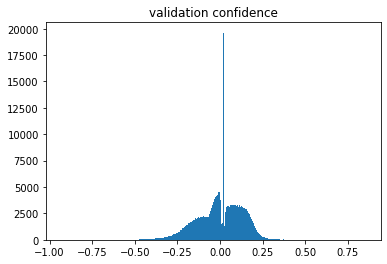

In [31]:
# distribution of confidence that will be used as submission
model.load_weights('models/TS-NN.hdf5')
confidence_valid = model.predict(X_valid)[:,0]*2 - 1
print(accuracy_score(confidence_valid>0,y_valid))
plt.hist(confidence_valid, bins='auto')
plt.title("validation confidence")
plt.show()

In [27]:
y_train

array([False,  True,  True, ..., False, False,  True])

In [29]:
y_valid

array([ True,  True,  True, ...,  True, False, False])

In [28]:
r_valid

array([ 0.01815718,  0.03168187,  0.00648607, ...,  0.06808248,
       -0.02604886, -0.01458425])

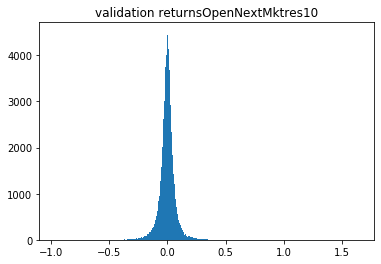

In [32]:
plt.hist(r_valid, bins='auto')
plt.title("validation returnsOpenNextMktres10")
plt.show()

In [34]:
# calculation of actual metric that is used to calculate final score
r_valid = r_valid.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_valid * r_valid * u_valid
data = {'day' : d_valid, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)

In [35]:
df.head()

,day,x_t_i
396263,2015-12-01,0.000000
452135,2016-01-19,-0.000495
739527,2016-09-01,-0.000208
887375,2016-12-28,0.000000
459293,2016-01-25,0.000000


In [36]:
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_valid = mean / std
print(score_valid)

0.7876677904000856
